# Market Reaction to Financial News: Train a model on financial news datasets to predict market movements based on news sentiment.

## 1 - a) State of the Art

## 1 - b) Dataset Description

### ** Description from Hugging Face**

Polar sentiment dataset of sentences from financial news. The dataset consists of 4840 sentences from English language financial news categorised by sentiment. The dataset is divided by agreement rate of 5-8 annotators.

- 0 Negative
- 1 Neutral
- 2 Positive

### ** Data Splits**

There's no train/validation/test split.

However the dataset is available in four possible configurations depending on the percentage of agreement of annotators:

- `sentences_50agree` Number of instances with >=50% annotator agreement: 4846 
- `sentences_66agree` Number of instances with >=66% annotator agreement: 4217 
- `sentences_75agree` Number of instances with >=75% annotator agreement: 3453 
- `sentences_allagree` Number of instances with 100% annotator agreement: 2264

The code below export all splits into csv files:

In [13]:
from datasets import load_dataset

splits = [
    "sentences_50agree",
    "sentences_66agree",
    "sentences_75agree",
    "sentences_allagree"
]

for split in splits:
    ds = load_dataset(
        "takala/financial_phrasebank",
        name=split,     # This is the agreement level
        trust_remote_code=True
    )

    ds['train'].to_csv(f'data/financial_phrasebank_{split}.csv')

Creating CSV from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Generating train split:   0%|          | 0/4217 [00:00<?, ? examples/s]

Creating CSV from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Generating train split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Creating CSV from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Generating train split:   0%|          | 0/2264 [00:00<?, ? examples/s]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

### ** Load File (financial_phrasebank_sentences_50agree)**

In [14]:
import os
import pandas as pd

file_path = "data/financial_phrasebank_sentences_50agree.csv"
df = pd.read_csv(file_path)
        
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Shape: (4846, 2)
Columns: ['sentence', 'label']


### Basic Info

In [15]:
df.head()


,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  4846 non-null   object
 1   label     4846 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [17]:
df.describe()

,label
count,4846.000000
mean,1.156624
std,0.617616
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


### **Distribution of Labels**

As expected, the dataset is imbalanced, with a higher number of neutral sentences compared to positive and negative ones. This is common in sentiment analysis datasets, especially in financial contexts where neutral (54.9%) statements are more frequent.

In [18]:
# Map numeric labels to sentiment names
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df['label_name'] = df['label'].map(label_map)

percentages = df['label_name'].value_counts(normalize=True) * 100
percentages.round(2)

label_name
Neutral     59.41
Positive    28.13
Negative    12.46
Name: proportion, dtype: float64

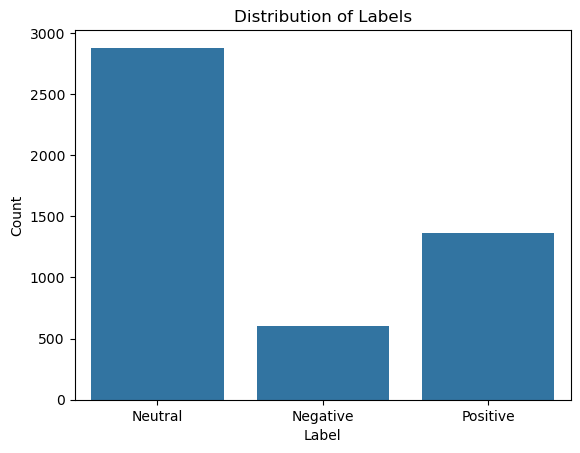

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt




sns.countplot(data=df, x='label_name')
sns.set(style="whitegrid")
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [1]:
from datasets import load_dataset

dataset_50agree = load_dataset("takala/financial_phrasebank", 'sentences_50agree', trust_remote_code=True)

### **Most frequent words**

The more frequent words in the dataset correspond to the most frequent words in the English language, such as "the", "and", "to", "of", etc. So we can perfom a stopword removal to focus on the more meaningful words in the dataset.

Text(0.5, 0, 'Words')

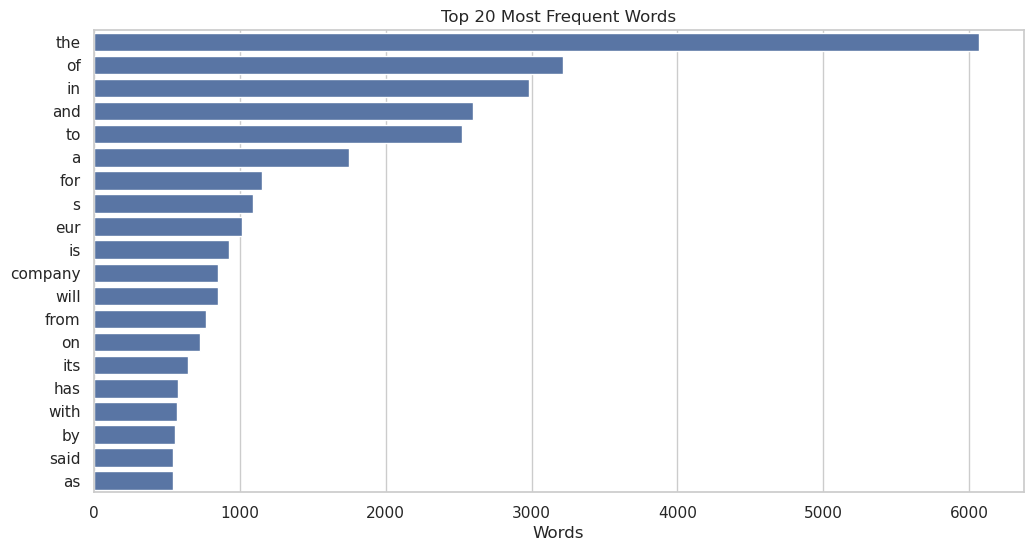

In [20]:
import pandas as pd
from collections import Counter
import re

# Tokenization: split sentences into words, convert to lowercase, and remove unwanted characters
def tokenize(text):
    # Converts text to lowercase and extracts words only (ignores numbers and punctuation)
    return re.findall(r'\b[a-záéíóúüñ]+\b', text.lower())

all_words = []
for sentence in df['sentence']:
    all_words.extend(tokenize(sentence))

# Count word frequency
counter = Counter(all_words)
most_common = counter.most_common(20)  # Top 20 most frequent words

plt.figure(figsize=(12, 6))
vertical = True  # Set to True for vertical bars, False for horizontal
if vertical:
    sns.set_style(style="whitegrid")  
sns.barplot(y=[word for word, freq in most_common], x=[freq for word, freq in most_common])

plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')     


### **Most frequent words without stopwords**

After applying stopwords removal, we can visualize the most common words again. This time, we will find words like eur, sales, and other financial terms that are more relevant to the dataset.

Finding eur instead of dollars or USD, shows that  the dataset is probably more focus on European financial.

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sobottka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text(0.5, 0, 'Words')

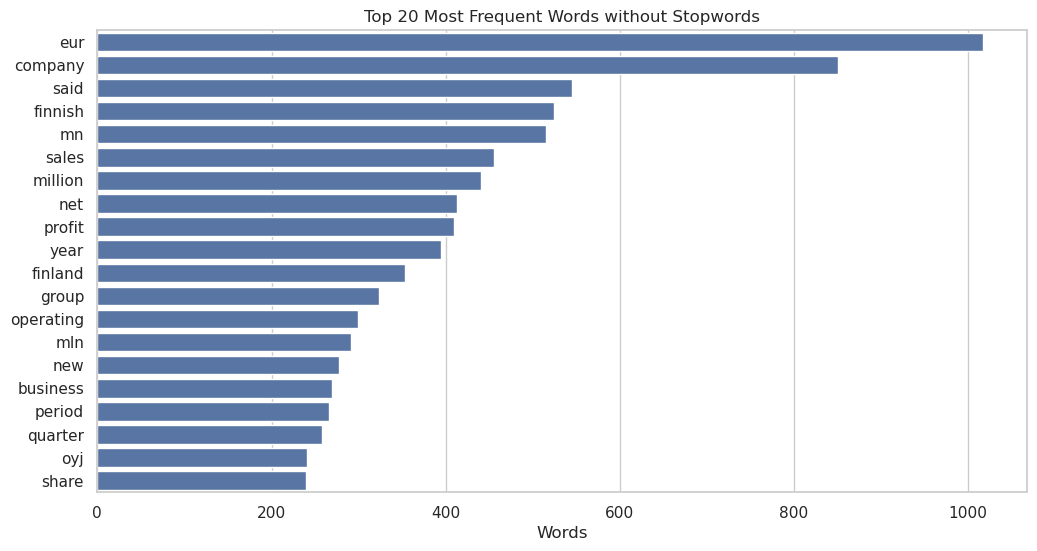

In [21]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Get list of English stopwords
stop_words = set(stopwords.words('english'))

# Filter out stopwords from the word list
filtered_words = [w for w in all_words if w not in stop_words]
filtered_counter = Counter(filtered_words)
most_common_filtered = filtered_counter.most_common(20)

plt.figure(figsize=(12, 6))
vertical = True  # Set to True for vertical bars, False for horizontal
if vertical:
    sns.set_style(style="whitegrid")  
sns.barplot(y=[word for word, freq in most_common_filtered], x=[freq for word, freq in most_common_filtered])

plt.title('Top 20 Most Frequent Words without Stopwords')
plt.xlabel('Words')     


## 1 - c) Random Classifier Performance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
dataset_50agree

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})

In [4]:
df_50agree = pd.DataFrame(dataset_50agree['train'])

In [5]:
df_50agree.head()

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2


In [6]:
grouped_df = df_50agree.groupby('label').size().reset_index(name='count')

In [7]:
grouped_df

,label,count
0,0,604
1,1,2879
2,2,1363


In [8]:
total_count = grouped_df['count'].sum()

In [9]:
# Convert counts to probabilities (empirical distribution)
grouped_df['Probability'] = (grouped_df['count'] / total_count)

In [10]:
grouped_df

,label,count,Probability
0,0,604,0.124639
1,1,2879,0.594098
2,2,1363,0.281263


Expected Accuracy = Probability of Correct Guess

To be correct, the randomly guessed label must match the true label. Let's compute the expected probability of that happening:

For each class i:

    The probability that a sample has label i is pᵢ

    The probability the classifier predicts label i is also pᵢ

    So, the probability of correctly predicting class i is:
    → pᵢ × pᵢ = pᵢ²

In [11]:
#Weighted random Classifier
expected_accuracy = np.array(np.sum(grouped_df['Probability']**2))
print(f"The expected accuracy of a random classifier (weighted) is: {expected_accuracy*100:.4}%")

#Uniform random Classifier
uniform_accuracy = 1/ len(grouped_df['Probability'])
print(f"The expected accuracy of a random classifier (uniform) is: {uniform_accuracy*100:.4}%")

The expected accuracy of a random classifier (weighted) is: 44.76%
The expected accuracy of a random classifier (uniform) is: 33.33%


## 1 - d) Baseline Implementation

In [22]:
positive_keywords = ["gain", "profit", "growth", "rise", "increased", "strong", "boost", "positive"]
negative_keywords = ["loss", "decline", "drop", "decreased", "weak", "fall", "negative"]


In [23]:
from datasets import load_dataset
from sklearn.metrics import classification_report
import re

# Load data
dataset = load_dataset("takala/financial_phrasebank", "sentences_50agree", trust_remote_code=True)
data = dataset['train']

# Define keyword rules
positive_keywords = ["gain", "profit", "growth", "rise", "increased", "strong", "boost", "positive"]
negative_keywords = ["loss", "decline", "drop", "decreased", "weak", "fall", "negative"]

def classify(sentence):
    sentence = sentence.lower()
    if any(re.search(rf"\b{word}\b", sentence) for word in positive_keywords):
        return 2
    elif any(re.search(rf"\b{word}\b", sentence) for word in negative_keywords):
        return 0
    else:
        return 1

# Predict using rules
y_true = data['label']
y_pred = [classify(s) for s in data['sentence']]

# Evaluate
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))


              precision    recall  f1-score   support

    Negative       0.59      0.16      0.25       604
     Neutral       0.67      0.96      0.79      2879
    Positive       0.56      0.24      0.34      1363

    accuracy                           0.66      4846
   macro avg       0.61      0.45      0.46      4846
weighted avg       0.63      0.66      0.60      4846



In [12]:
sorted_df = df_50agree.sort_values(by='sentence', ascending=True)
sorted_df.head(100)

,sentence,label
3741,'s Outokumpu Technology business will begin tr...,1
3012,( A spokesperson told WWD to expect a 50-50 mi...,1
591,"( ADP News ) - Dec 11 , 2008 - Finnish constru...",2
3013,"( ADP News ) - Dec 11 , 2008 - Finnish power-s...",1
227,"( ADP News ) - Feb 11 , 2009 - Finnish managem...",2
...,...,...
1487,3G data subscribers are also helping to mainta...,1
413,4 ) Complete name of the shareholder : Otto He...,1
2268,4 February 2011 - Finnish broadband data commu...,2
92,4 February 2011 - Finnish broadband data commu...,2
